In [19]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from adjustText import adjust_text


import warnings
warnings.filterwarnings("ignore")

# Load unseen-species model data
path = 'unseen_species_model/unseen_species_model.csv'
df_cultura = pd.read_csv(path, index_col = [0])
df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})


# Load individuals Data
df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])

### Make function

In [20]:
def plot_figure(region_name, 
                max_year, 
                min_year, 
                period_data, 
                year_step = 200, 
                plot_names = True, 
                frac = 0.1, 
                top_n_individuals = 15,
                plot_bars = False,
                plot_original_trend = False,
                yticks = [5, 10, 50, 100, 500, 1000, 2000]):


    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name])]
        

    df = df_cultura[df_cultura['region_name'].isin([region_name])]
    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]
    df['N_est'] = np.log(df['N_est'])  # Applying log transformation
    df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
    df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
    df['score'] = np.log(df['score'])  # Max bound log


    # Define your color scheme
    colors = {
        region_name: "#00008b",
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing
            smoothed = lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)

            # Texts for top 15
            for _, row in top_individuals.iterrows():
                score_normalized = (row['score'] / max_global_score) * max_n_est
                text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                            ha='center', va='bottom', color='red',fontsize=8)
                texts.append(text)

            # Use adjust_text for the current region with the corresponding arrow color
            adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.1, zorder=2)


   
    yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels




    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    ax.set_title(region_name, fontsize = 16)
    ax.legend().remove()
    plt.show()


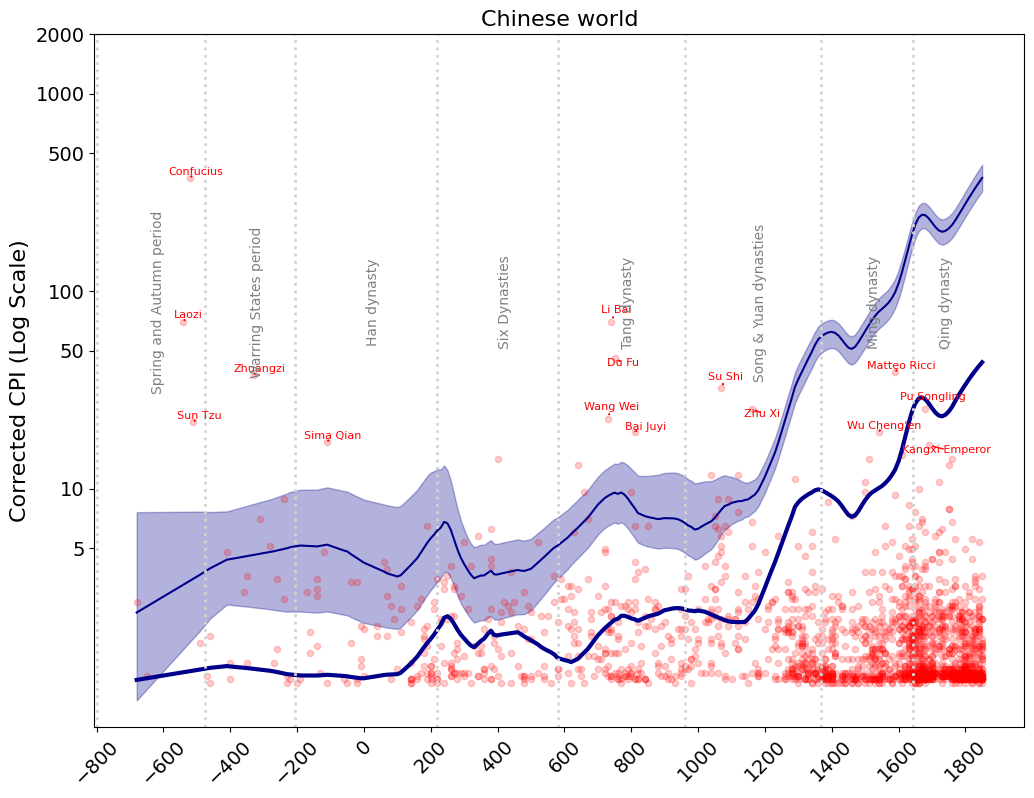

In [21]:
region_name = 'Chinese world'
min_year = -800
max_year = 1850


period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}


plot_figure(region_name, max_year, min_year, period_data, year_step = 200, plot_original_trend = True)


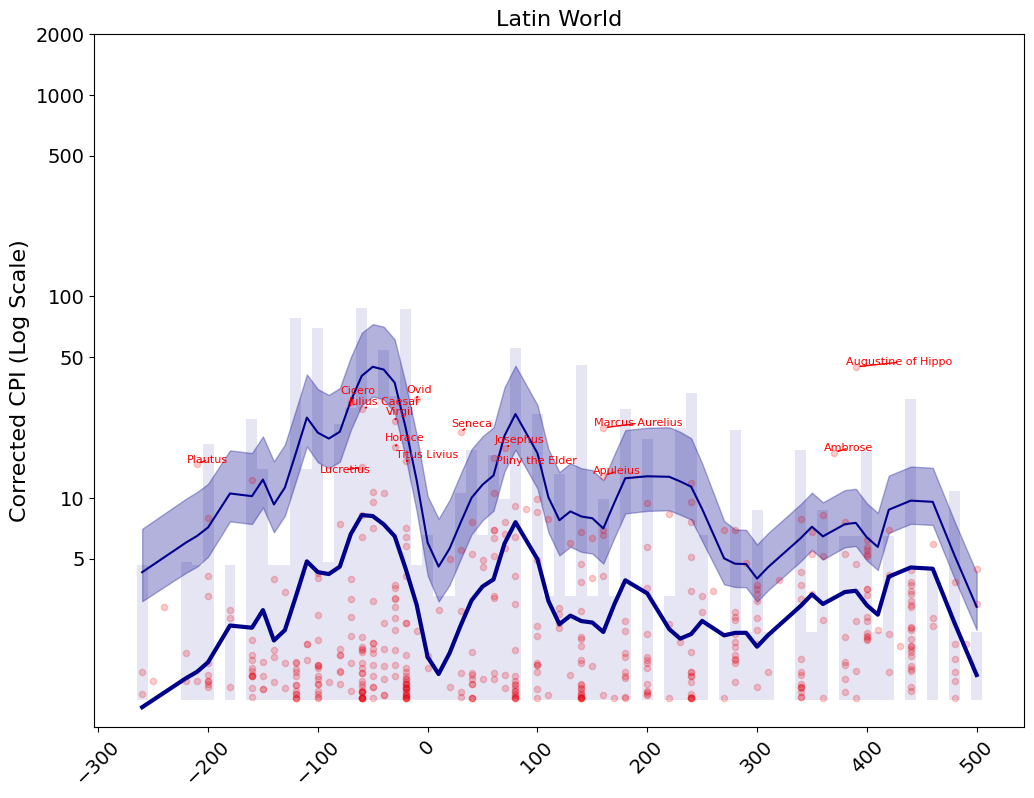

In [22]:
plot_figure(region_name = 'Latin World', min_year = -300, max_year = 500, period_data = None,  year_step = 100, frac=0.1, plot_bars = True, plot_original_trend = True)

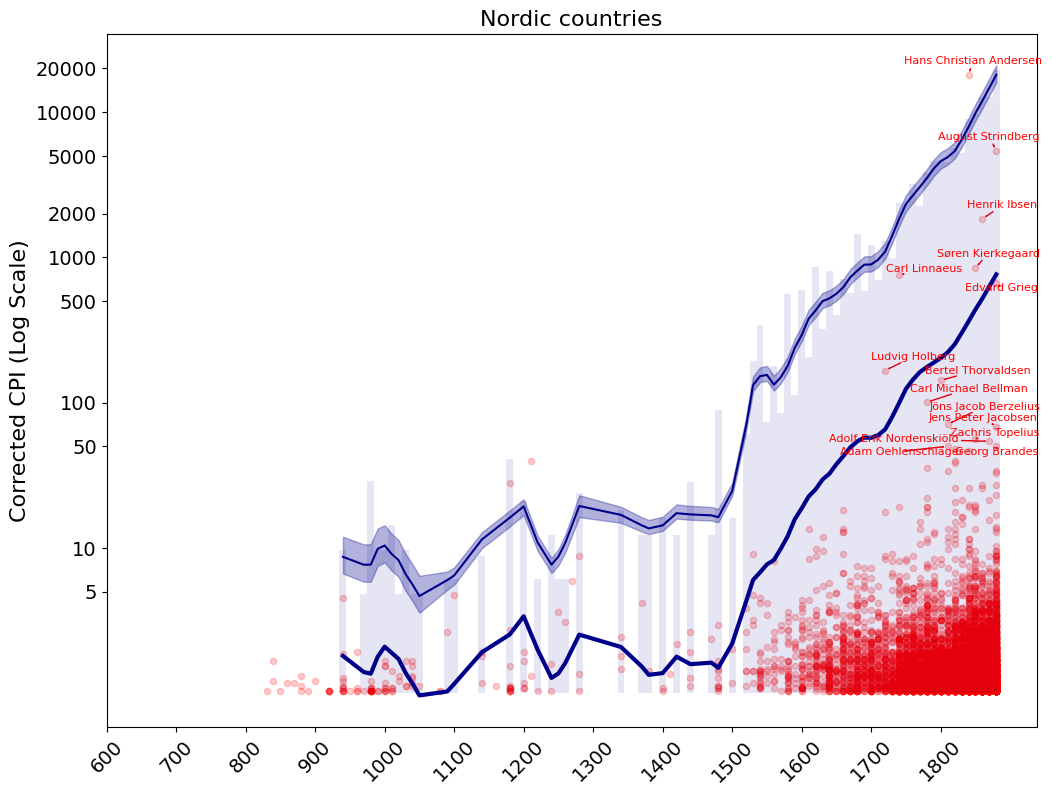

In [23]:
plot_figure(region_name = 'Nordic countries', min_year = 600, max_year = 1880,period_data = None,  year_step = 100, frac=0.1, plot_bars = True,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

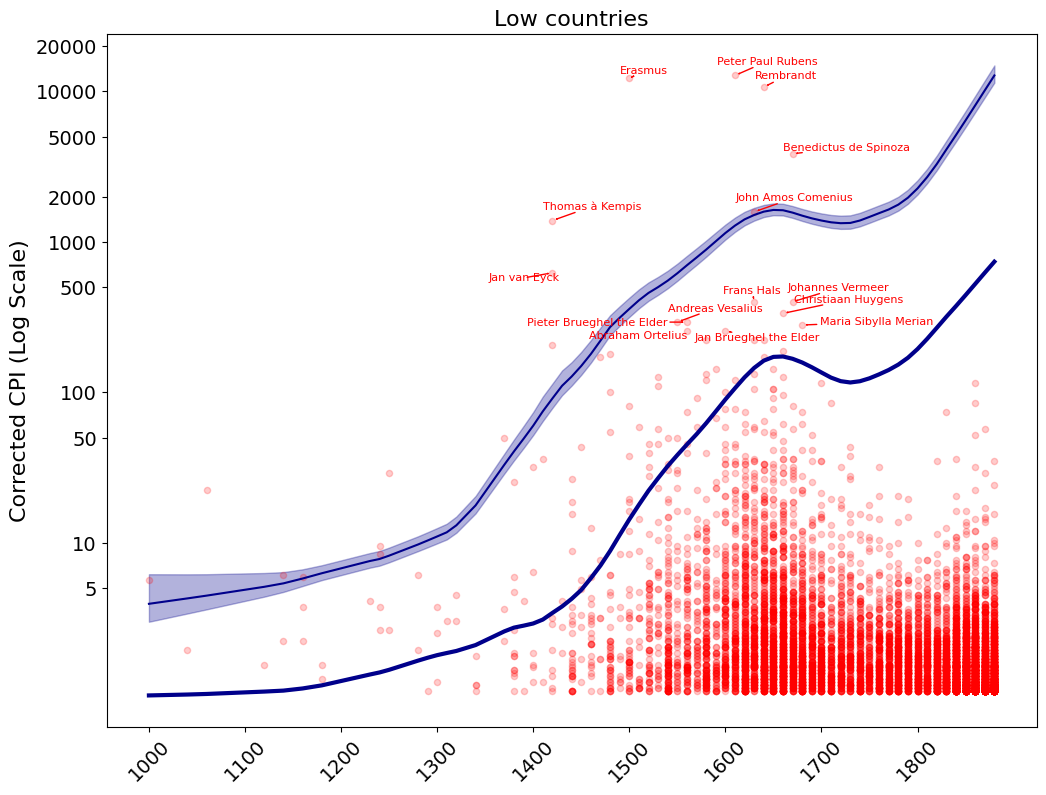

In [24]:
plot_figure(region_name = 'Low countries', min_year = 1000, max_year = 1880,period_data = None,  year_step = 100, frac=0.2,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

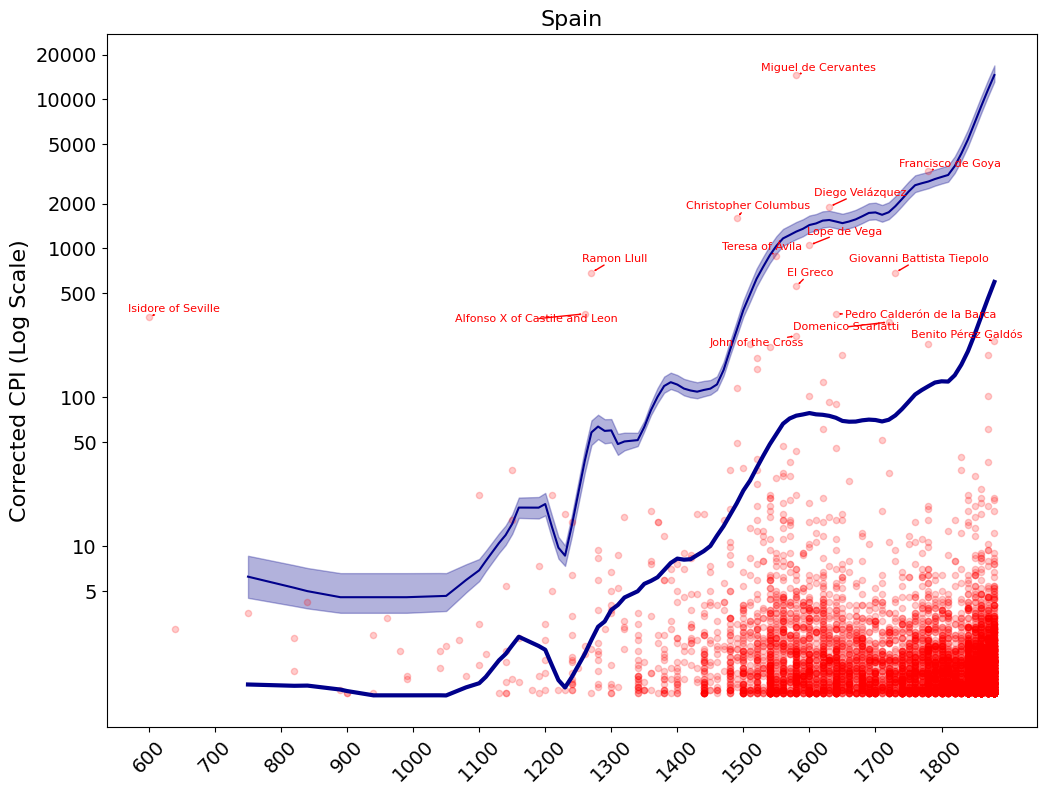

In [25]:
plot_figure(region_name = 'Spain', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

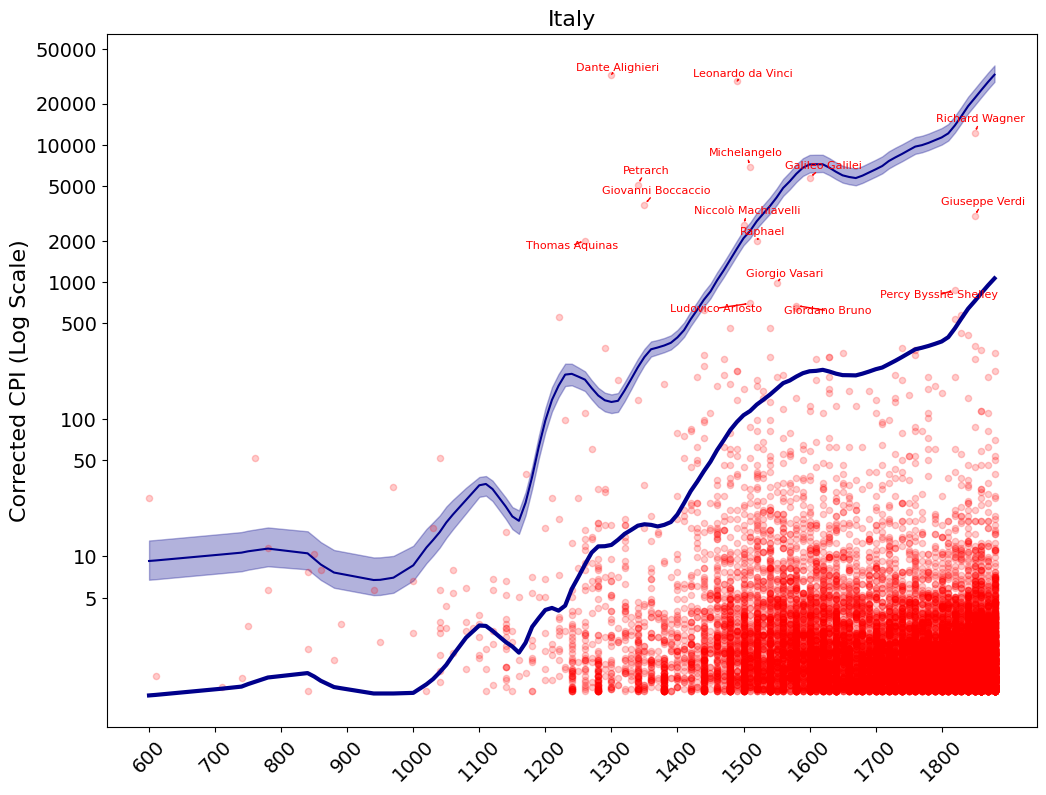

In [26]:
plot_figure(region_name = 'Italy', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

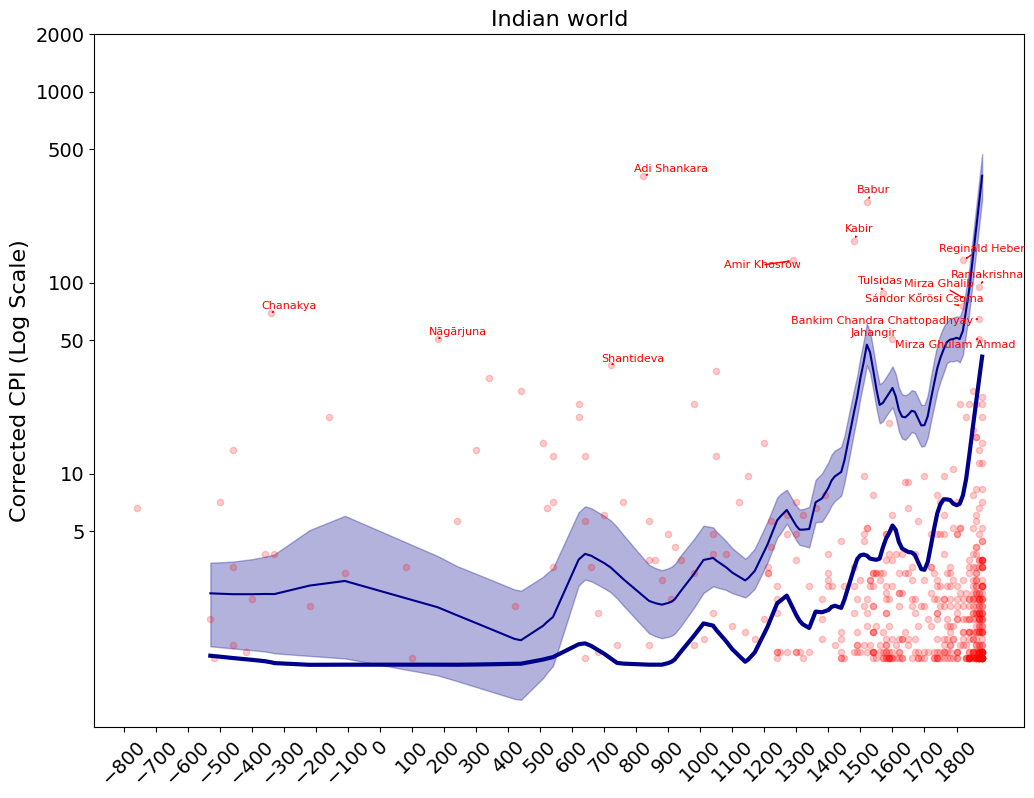

In [27]:
plot_figure(region_name = 'Indian world', min_year = -800, max_year = 1880,period_data = None,  year_step = 100,plot_original_trend = True)

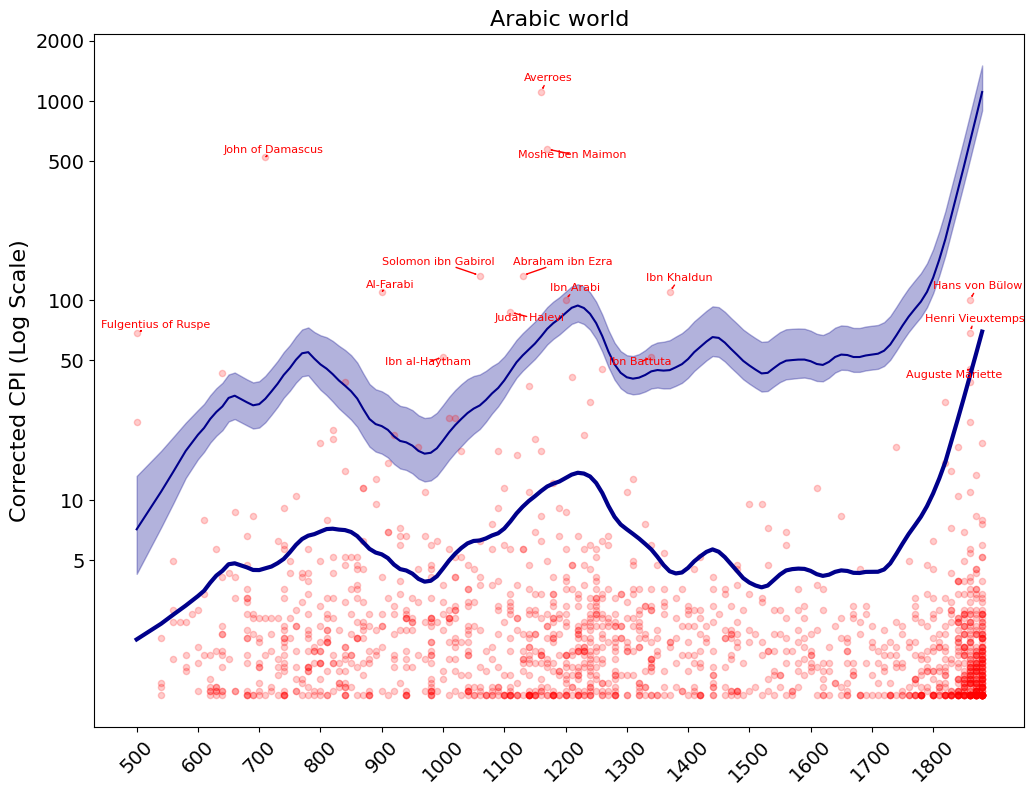

In [28]:
plot_figure(region_name = 'Arabic world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True)

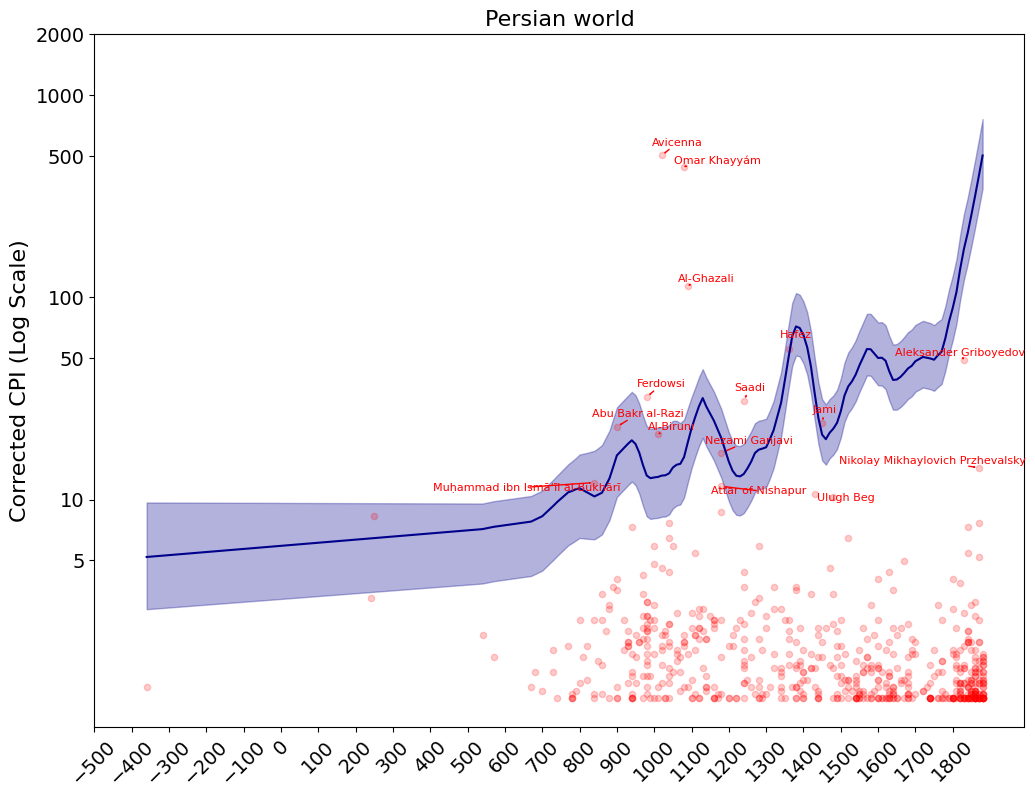

In [29]:
plot_figure(region_name = 'Persian world', min_year = -500, max_year = 1880,period_data = None,  year_step = 100)

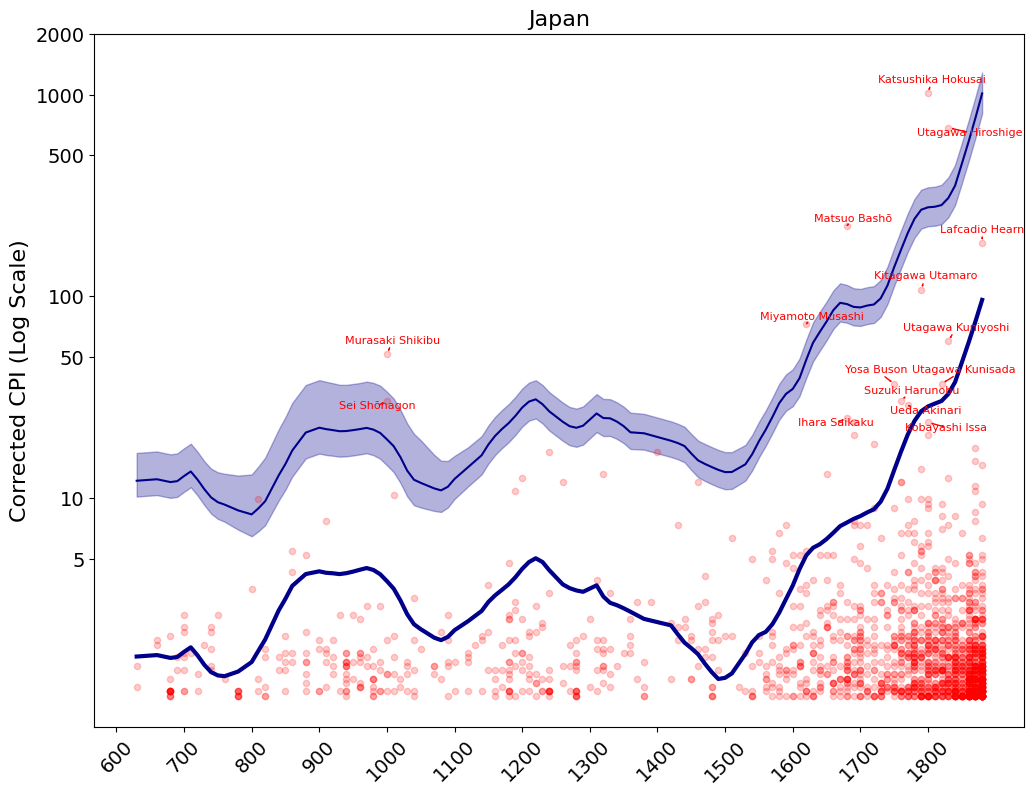

In [30]:
plot_figure(region_name = 'Japan', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True)

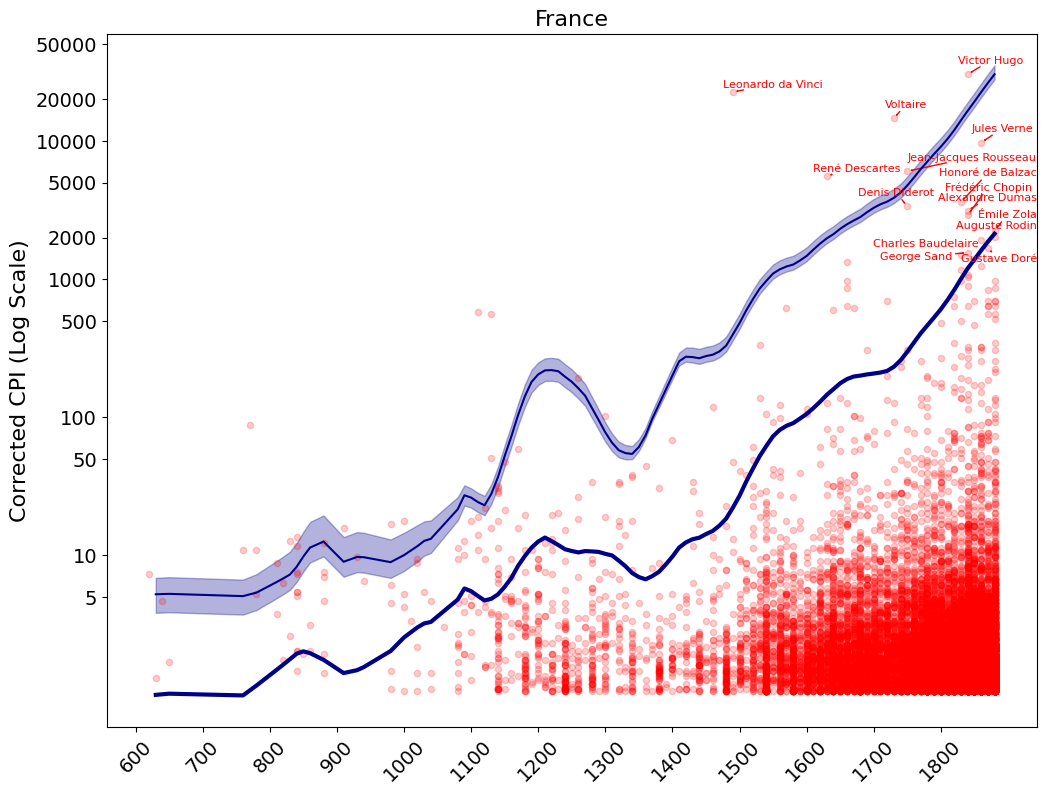

In [31]:
plot_figure(region_name = 'France', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

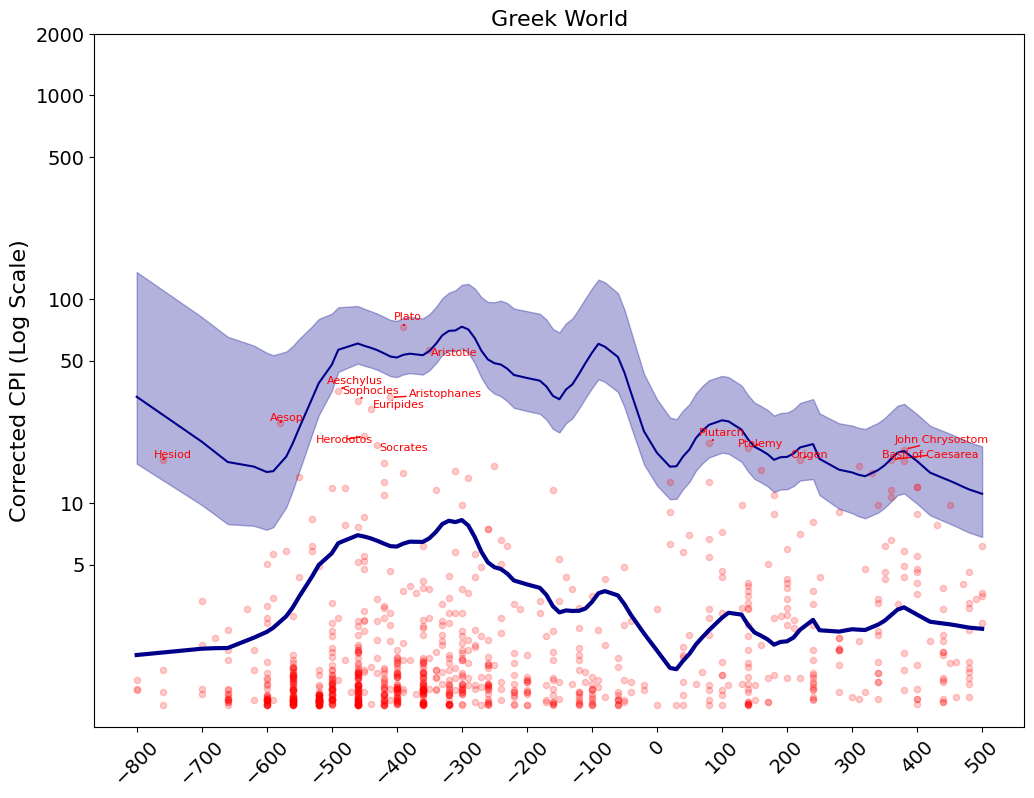

In [32]:
plot_figure(region_name = 'Greek World', min_year = -800, max_year = 500,period_data = None,  year_step = 100, frac = 0.15,  plot_original_trend = True)

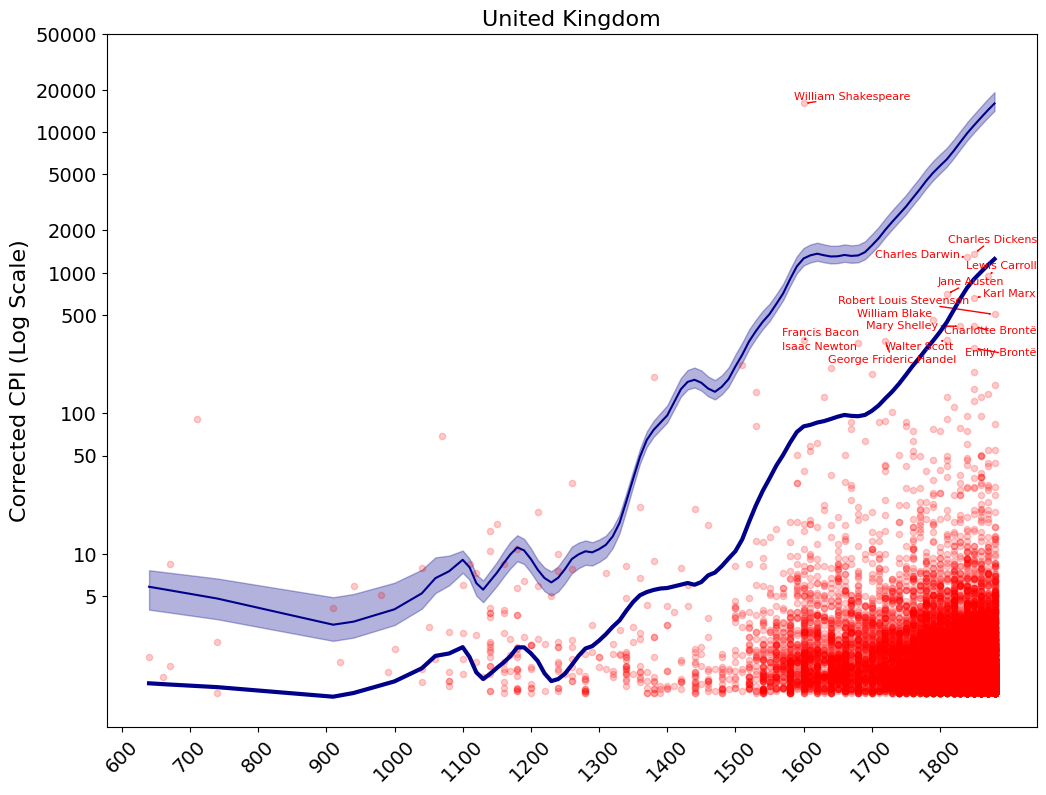

In [33]:
plot_figure(region_name = 'United Kingdom', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

### Western Europe

### Plot 2 figures

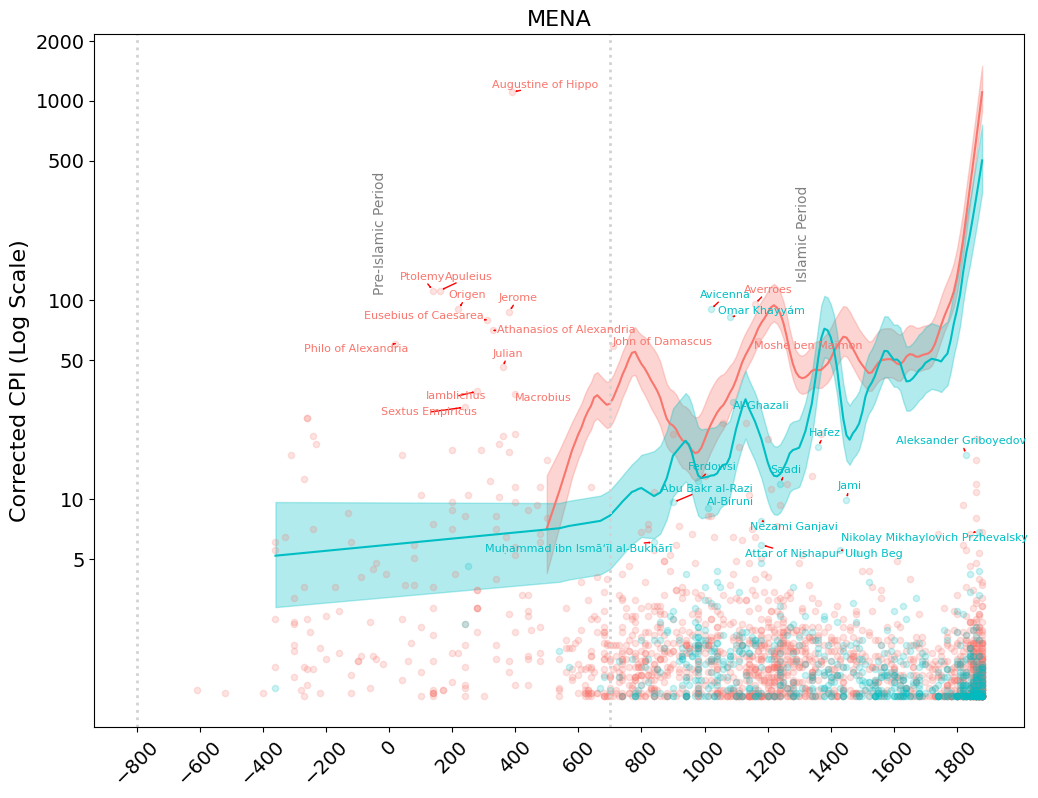

In [35]:
def plot_figures(region_name_1, 
                 region_name_2,
                    max_year, 
                    min_year, 
                    period_data, 
                    title,
                    year_step = 200, 
                    plot_names = True, 
                    frac = 0.1, 
                    top_n_individuals = 15,
                    plot_bars = False,
                    plot_original_trend = False,
                    ):


    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name_1, region_name_2])]
    
    df = df_cultura[df_cultura['region_name'].isin([region_name_1, region_name_2])]
    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]
    df['N_est'] = np.log(df['N_est'])  # Applying log transformation
    df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
    df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
    df['score'] = np.log(df['score'])  # Max bound log


    # Define your color scheme
    colors = {
        region_name_1: "#00bfc4",
        region_name_2: "#f8766d"
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing
            smoothed = lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

            # Texts for top 15
            for _, row in top_individuals.iterrows():
                score_normalized = (row['score'] / max_global_score) * max_n_est
                text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                            ha='center', va='bottom', color=colors[region],fontsize=8)
                texts.append(text)

            # Use adjust_text for the current region with the corresponding arrow color
            adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.2, zorder=2)


    # Define specific y-ticks and convert them to log scale for plotting
    yticks = [5, 10, 50, 100, 500, 1000, 2000]
    yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.legend().remove()
    plt.show()



plot_figures(region_name_1="Persian world", 
            region_name_2='Arabic world',
                max_year = 1880, 
                min_year = -800, 
                title='MENA',
                period_data = {
                "x_intercepts": [
                    [-800, 700],
                    [700, 1880],
                
                ],
                "labels": [
                    "Pre-Islamic Period",
                    "Islamic Period",
                ]
            }, 
                year_step = 200, 
                plot_names = True, 
                frac = 0.1, 
                top_n_individuals = 15,
                plot_bars = False,
                plot_original_trend = False)

### Plot Western Europe

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess


df_cultura = pd.read_csv(path, index_col = [0])
df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1800]
#df_cultura = df_cultura[df_cultura['decade']>=600]


df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])
df_individuals = df_individuals[df_individuals['decade']<=1800]
#df_individuals = df_individuals[df_individuals['decade']>=600]


list(set(df_cultura.region_name))

regions_eu = ['Latin World',
 'Portugal',
 'Italy',
#  'Greek World',
 'Spain',
 'Nordic countries',
 'German world',
 'Low countries',
 'France',
 'United Kingdom']


df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]
df_cultura = df_cultura.groupby('decade').sum().reset_index()

df_individuals =df_individuals[df_individuals['region_name'].isin(regions_eu)]


df_cultura['region_name']='Western Europe'
df_individuals['region_name']='Western Europe'

df_individuals.sort_values('score', ascending=False)

df = df_cultura.copy()


# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# Define your color scheme
colors = {
    "Western Europe": "#00008b",
}

fig, ax = plt.subplots(figsize=(12, 9))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=0.1)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.1)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.1)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

# Calculate the maximum score for all individuals for normalization
max_global_score = df_individuals['score'].max()

# Collect texts from each region separately and adjust
for region in df_individuals['region_name'].unique():
    region_individuals = df_individuals[df_individuals['region_name'] == region]
    region_individuals = region_individuals.sort_values('score', ascending=False)
    top_individuals = region_individuals.head(30).sort_values('score', ascending=False)
    texts = []  # Initialize a new list for this region's texts

    # Plot scatter for all individuals
    all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
    ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20, zorder=3)

    # Texts for top 15
    for _, row in top_individuals.iterrows():
        score_normalized = (row['score'] / max_global_score) * max_n_est
        text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                       ha='center', va='bottom', color='red',fontsize=8)
        texts.append(text)

    # Use adjust_text for the current region with the corresponding arrow color
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('Western Europe', fontsize = 16)
ax.legend().remove()
plt.show()



